## A) Importing Necessary Libraries

In [1]:
import findspark
findspark.init()
import pyspark, time
import numpy as np
from datetime import datetime
from pyspark.sql.functions import length,col
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, IntegerType, StringType, DoubleType, DateType
from pyspark.ml.feature import HashingTF, IDF, Tokenizer, StringIndexer, CountVectorizer, NGram, VectorAssembler, ChiSqSelector
from pyspark.ml import Pipeline
from pyspark.ml.classification import DecisionTreeClassifier, NaiveBayes, LogisticRegression, RandomForestClassifier, LinearSVC
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator


## B) Exploratory Data Analysis

In [2]:
spark1 = SparkSession.builder.getOrCreate()

path = "./training.1600000.processed.noemoticon.csv"

schema = StructType([
    StructField("target", IntegerType(), True),
    StructField("id", StringType(), True),
    StructField("date", StringType(), True),
    StructField("query", StringType(), True),
    StructField("author", StringType(), True),
    StructField("tweet", StringType(), True)])

df = spark1.read.csv(path,
                     inferSchema=True,
                     header=False,
                     schema=schema)

positive_tweets = df.filter(col("target") == 4).limit(5000)
negative_tweets = df.filter(col("target") == 0).limit(5000)

# Combine positive and negative tweets
df = positive_tweets.union(negative_tweets)

df.show()

+------+----------+--------------------+--------+---------------+--------------------+
|target|        id|                date|   query|         author|               tweet|
+------+----------+--------------------+--------+---------------+--------------------+
|     4|1467822272|Mon Apr 06 22:22:...|NO_QUERY|          ersle|I LOVE @Health4Ua...|
|     4|1467822273|Mon Apr 06 22:22:...|NO_QUERY|       becca210|im meeting up wit...|
|     4|1467822283|Mon Apr 06 22:22:...|NO_QUERY|      Wingman29|@DaRealSunisaKim ...|
|     4|1467822287|Mon Apr 06 22:22:...|NO_QUERY|      katarinka|Being sick can be...|
|     4|1467822293|Mon Apr 06 22:22:...|NO_QUERY|    _EmilyYoung|@LovesBrooklyn2 h...|
|     4|1467822391|Mon Apr 06 22:22:...|NO_QUERY|  ajarofalmonds|@ProductOfFear Yo...|
|     4|1467822447|Mon Apr 06 22:22:...|NO_QUERY|      vmdavinci|@r_keith_hill Tha...|
|     4|1467822465|Mon Apr 06 22:22:...|NO_QUERY|  jessicavaliyi|@KeepinUpWKris I ...|
|     4|1467822489|Mon Apr 06 22:22:...|NO_

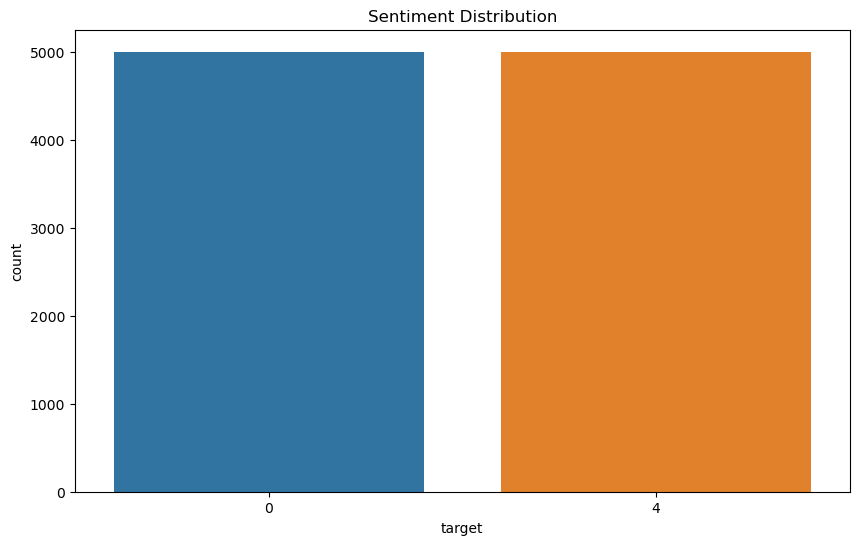

In [3]:
# Add a column for the length of each tweet
df1 = df.withColumn("text_length", length("tweet"))

# Convert to Pandas DataFrame for visualization
df_pd = df1.toPandas()

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# 1. Sentiment Distribution Plot
plt.figure(figsize=(10, 6))
sns.countplot(x='target', data=df_pd)
plt.title('Sentiment Distribution')
plt.show()

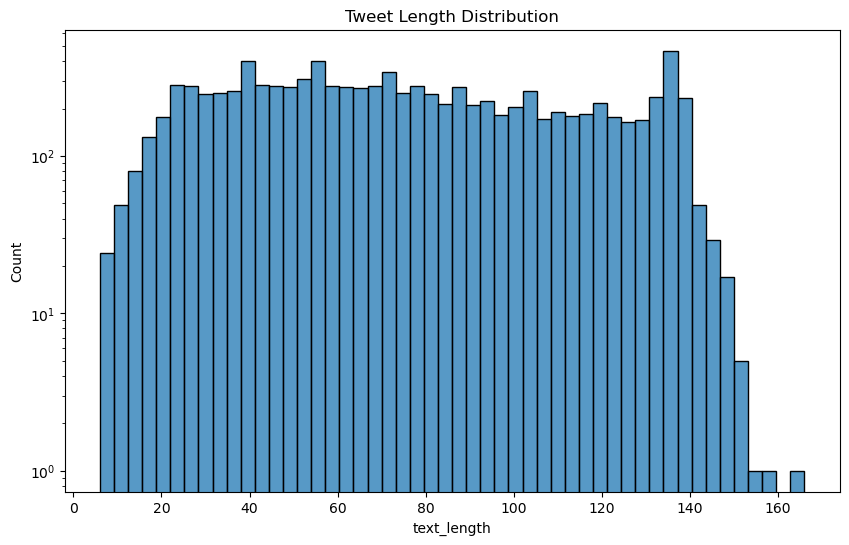

In [4]:
# 2. Tweet Length Distribution
plt.figure(figsize=(10, 6))
sns.histplot(df_pd['text_length'], bins=50)
plt.yscale('log')  # Using logarithmic scale for better visualization of smaller values
plt.title('Tweet Length Distribution')
plt.show()


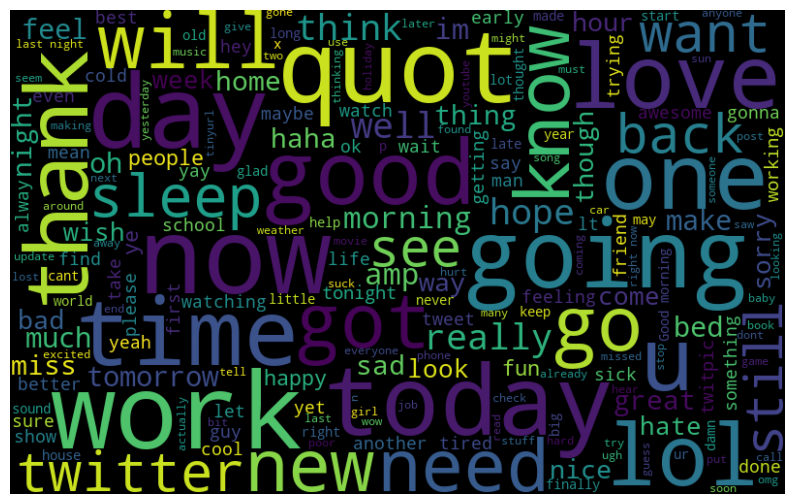

In [5]:
# 3. Word Cloud for most common words
all_words = ' '.join([text for text in df_pd['tweet']])
wordcloud = WordCloud(width=800, height=500, max_font_size=110).generate(all_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

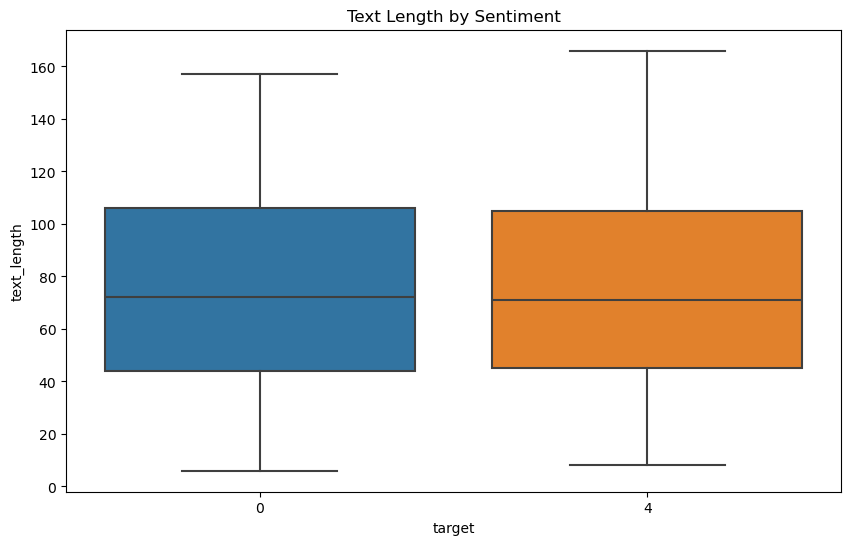

In [6]:
# 4. Box Plot for Text Length by Sentiment
plt.figure(figsize=(10, 6))
sns.boxplot(x='target', y='text_length', data=df_pd)
plt.title('Text Length by Sentiment')
plt.show()

##  C) Applying Different Machine Learning Models to Data

### 1. Decision Tree Classifier

#### i) HashingTF - IDF


In [7]:
(train_set, test_set) = df.randomSplit([0.80, 0.20])

tokenizer = Tokenizer(inputCol="tweet", outputCol="words")
hashtf = HashingTF(numFeatures=2**16, inputCol="words", outputCol='tf')
idf = IDF(inputCol='tf', outputCol="features", minDocFreq=5) #minDocFreq: remove sparse terms
label_stringIdx = StringIndexer(inputCol = "target", outputCol = "label")

dt = DecisionTreeClassifier()

evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
pipeline = Pipeline(stages=[tokenizer, hashtf, idf, label_stringIdx, dt])

pipelineFit = pipeline.fit(train_set)

predictions = pipelineFit.transform(test_set)

accuracy = evaluator.evaluate(predictions, {evaluator.metricName: "accuracy"})
precision = evaluator.evaluate(predictions, {evaluator.metricName: "weightedPrecision"})
recall = evaluator.evaluate(predictions, {evaluator.metricName: "weightedRecall"})

# Print the results
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.5812345679012346
Precision: 0.5956491497451692
Recall: 0.5812345679012346


#### ii) CountVectorizer - IDF

In [8]:
tokenizer = Tokenizer(inputCol="tweet", outputCol="words")
cv = CountVectorizer(vocabSize=2**16, inputCol="words", outputCol='cv')
idf = IDF(inputCol='cv', outputCol="features", minDocFreq=5) #minDocFreq: remove sparse terms
label_stringIdx = StringIndexer(inputCol = "target", outputCol = "label")

dt = DecisionTreeClassifier()
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")

pipeline = Pipeline(stages=[tokenizer, cv, idf, label_stringIdx, dt])

pipelineFit = pipeline.fit(train_set)

predictions = pipelineFit.transform(test_set)

accuracy = evaluator.evaluate(predictions, {evaluator.metricName: "accuracy"})
precision = evaluator.evaluate(predictions, {evaluator.metricName: "weightedPrecision"})
recall = evaluator.evaluate(predictions, {evaluator.metricName: "weightedRecall"})

# Print the results
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.5743209876543209
Precision: 0.6250381407242895
Recall: 0.5743209876543209


#### iii) CountVectorizer + NGram + ChisQSelector

In [9]:
def build_trigrams(inputCol=["tweet","target"], n=3):
    
    tokenizer = [Tokenizer(inputCol="tweet", outputCol="words")]
    
    ngrams = [
        NGram(n=i, inputCol="words", outputCol="{0}_grams".format(i))
        for i in range(1, n + 1)
    ]

    cv = [
        CountVectorizer(vocabSize=2**14,inputCol="{0}_grams".format(i),
            outputCol="{0}_tf".format(i))
        for i in range(1, n + 1)
    ]
    
    idf = [IDF(inputCol="{0}_tf".format(i), outputCol="{0}_tfidf".format(i), minDocFreq=5) for i in range(1, n + 1)]

    assembler = [VectorAssembler(
        inputCols=["{0}_tfidf".format(i) for i in range(1, n + 1)],
        outputCol="rawFeatures"
    )]
    
    label_stringIdx = [StringIndexer(inputCol = "target", outputCol = "label")]
    
    selector = [ChiSqSelector(numTopFeatures=2**14,featuresCol='rawFeatures', outputCol="features")]
    
    dt = [DecisionTreeClassifier()]
    
    return Pipeline(stages=tokenizer + ngrams + cv + idf + assembler + label_stringIdx + selector + dt)

pipelineFit = build_trigrams().fit(train_set)

predictions = pipelineFit.transform(test_set)

accuracy = evaluator.evaluate(predictions, {evaluator.metricName: "accuracy"})
precision = evaluator.evaluate(predictions, {evaluator.metricName: "weightedPrecision"})
recall = evaluator.evaluate(predictions, {evaluator.metricName: "weightedRecall"})

# Print the results
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.5723456790123457
Precision: 0.6221666460004515
Recall: 0.5723456790123457


### 2. Logistic Regression

#### i) HashingTF - IDF

In [10]:
(train_set, test_set) = df.randomSplit([0.80, 0.20], seed = 2000)

tokenizer = Tokenizer(inputCol="tweet", outputCol="words")
hashtf = HashingTF(inputCol="words", outputCol='tf')
idf = IDF(inputCol='tf', outputCol="features")

label_stringIdx = StringIndexer(inputCol = "target", outputCol = "label")

lr = LogisticRegression()
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")

pipeline = Pipeline(stages=[tokenizer, hashtf, idf, label_stringIdx, lr])

pipelineFit = pipeline.fit(train_set)

predictions = pipelineFit.transform(test_set)

accuracy = evaluator.evaluate(predictions, {evaluator.metricName: "accuracy"})
precision = evaluator.evaluate(predictions, {evaluator.metricName: "weightedPrecision"})
recall = evaluator.evaluate(predictions, {evaluator.metricName: "weightedRecall"})

# Print the results
print("Accuracy(Default Params):", accuracy)
print("Precision(Default Params):", precision)
print("Recall(Default Params):", recall)

Accuracy(Default Params): 0.668
Precision(Default Params): 0.6691326378539493
Recall(Default Params): 0.6679999999999999


In [11]:
tokenizer = Tokenizer(inputCol="tweet", outputCol="words")
hashtf = HashingTF(numFeatures=2**16, inputCol="words", outputCol='tf')
idf = IDF(inputCol='tf', outputCol="features", minDocFreq=5) #minDocFreq: remove sparse terms

label_stringIdx = StringIndexer(inputCol = "target", outputCol = "label")

lr = LogisticRegression()
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")

pipeline = Pipeline(stages=[tokenizer, hashtf, idf, label_stringIdx, lr])

pipelineFit = pipeline.fit(train_set)

predictions = pipelineFit.transform(test_set)

accuracy = evaluator.evaluate(predictions, {evaluator.metricName: "accuracy"})
precision = evaluator.evaluate(predictions, {evaluator.metricName: "weightedPrecision"})
recall = evaluator.evaluate(predictions, {evaluator.metricName: "weightedRecall"})

# Print the results
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.6835
Precision: 0.6836780389532575
Recall: 0.6835


#### ii) CountVectorizer - IDF

In [12]:
tokenizer = Tokenizer(inputCol="tweet", outputCol="words")
cv = CountVectorizer(vocabSize=2**16, inputCol="words", outputCol='cv')
idf = IDF(inputCol='cv', outputCol="features", minDocFreq=5) #minDocFreq: remove sparse terms

label_stringIdx = StringIndexer(inputCol = "target", outputCol = "label")

lr = LogisticRegression()
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")

pipeline = Pipeline(stages=[tokenizer, cv, idf, label_stringIdx, lr])


pipelineFit = pipeline.fit(train_set)

predictions = pipelineFit.transform(test_set)

accuracy = evaluator.evaluate(predictions, {evaluator.metricName: "accuracy"})
precision = evaluator.evaluate(predictions, {evaluator.metricName: "weightedPrecision"})
recall = evaluator.evaluate(predictions, {evaluator.metricName: "weightedRecall"})

# Print the results
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)


Accuracy: 0.698
Precision: 0.6980439601758407
Recall: 0.698


#### iii) CountVectorizer + NGram + ChisQSelector

In [13]:
def build_trigrams(inputCol=["tweet","target"], n=3):
    
    tokenizer = [Tokenizer(inputCol="tweet", outputCol="words")]
    
    ngrams = [
        NGram(n=i, inputCol="words", outputCol="{0}_grams".format(i))
        for i in range(1, n + 1)
    ]

    cv = [
        CountVectorizer(vocabSize=2**14,inputCol="{0}_grams".format(i),
            outputCol="{0}_tf".format(i))
        for i in range(1, n + 1)
    ]
    
    idf = [IDF(inputCol="{0}_tf".format(i), outputCol="{0}_tfidf".format(i), minDocFreq=5) for i in range(1, n + 1)]

    assembler = [VectorAssembler(
        inputCols=["{0}_tfidf".format(i) for i in range(1, n + 1)],
        outputCol="rawFeatures"
    )]
    
    label_stringIdx = [StringIndexer(inputCol = "target", outputCol = "label")]
    
    selector = [ChiSqSelector(numTopFeatures=2**14,featuresCol='rawFeatures', outputCol="features")]
    
    lr = [LogisticRegression()]
    
    return Pipeline(stages=tokenizer + ngrams + cv + idf + assembler + label_stringIdx + selector + lr)

pipelineFit = build_trigrams().fit(train_set)
predictions = pipelineFit.transform(test_set)
accuracy = evaluator.evaluate(predictions, {evaluator.metricName: "accuracy"})
precision = evaluator.evaluate(predictions, {evaluator.metricName: "weightedPrecision"})
recall = evaluator.evaluate(predictions, {evaluator.metricName: "weightedRecall"})

# Print the results
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.6755
Precision: 0.6755173676563089
Recall: 0.6755


### 3. Naive Bayes Classifier

#### i) HashingTF - IDF

In [14]:
tokenizer = Tokenizer(inputCol="tweet", outputCol="words")
hashtf = HashingTF(numFeatures=2**16, inputCol="words", outputCol='tf')
idf = IDF(inputCol='tf', outputCol="features", minDocFreq=5) #minDocFreq: remove sparse terms

label_stringIdx = StringIndexer(inputCol = "target", outputCol = "label")

nb = NaiveBayes(modelType="multinomial")
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")

pipeline = Pipeline(stages=[tokenizer, hashtf, idf, label_stringIdx, nb])

pipelineFit = pipeline.fit(train_set)

predictions = pipelineFit.transform(test_set)

accuracy = evaluator.evaluate(predictions, {evaluator.metricName: "accuracy"})
precision = evaluator.evaluate(predictions, {evaluator.metricName: "weightedPrecision"})
recall = evaluator.evaluate(predictions, {evaluator.metricName: "weightedRecall"})

# Print the results
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.7015
Precision: 0.7028966909652925
Recall: 0.7015


#### ii) CountVectorizer

In [15]:
tokenizer = Tokenizer(inputCol="tweet", outputCol="words")
cv = CountVectorizer(vocabSize=2**16, inputCol="words", outputCol='cv')
idf = IDF(inputCol='cv', outputCol="features", minDocFreq=5) #minDocFreq: remove sparse terms
label_stringIdx = StringIndexer(inputCol = "target", outputCol = "label")
nb = NaiveBayes(modelType="multinomial")
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
pipeline = Pipeline(stages=[tokenizer, cv, idf, label_stringIdx, nb])

pipelineFit = pipeline.fit(train_set)
predictions = pipelineFit.transform(test_set)
accuracy = evaluator.evaluate(predictions, {evaluator.metricName: "accuracy"})
precision = evaluator.evaluate(predictions, {evaluator.metricName: "weightedPrecision"})
recall = evaluator.evaluate(predictions, {evaluator.metricName: "weightedRecall"})

# Print the results
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.712
Precision: 0.7126278632396199
Recall: 0.712


#### iii) CountVectorizer + NGram + ChisQSelector



In [16]:
def build_trigrams(inputCol=["tweet","target"], n=3):
    
    tokenizer = [Tokenizer(inputCol="tweet", outputCol="words")]
    
    ngrams = [
        NGram(n=i, inputCol="words", outputCol="{0}_grams".format(i))
        for i in range(1, n + 1)
    ]

    cv = [
        CountVectorizer(vocabSize=2**14,inputCol="{0}_grams".format(i),
            outputCol="{0}_tf".format(i))
        for i in range(1, n + 1)
    ]
    
    idf = [IDF(inputCol="{0}_tf".format(i), outputCol="{0}_tfidf".format(i), minDocFreq=5) for i in range(1, n + 1)]

    assembler = [VectorAssembler(
        inputCols=["{0}_tfidf".format(i) for i in range(1, n + 1)],
        outputCol="rawFeatures"
    )]
    
    label_stringIdx = [StringIndexer(inputCol = "target", outputCol = "label")]
    
    selector = [ChiSqSelector(numTopFeatures=2**14,featuresCol='rawFeatures', outputCol="features")]
    
    nb = [NaiveBayes(modelType="multinomial")]
    
    return Pipeline(stages=tokenizer + ngrams + cv + idf + assembler + label_stringIdx + selector + nb)

pipelineFit = build_trigrams().fit(train_set)

predictions = pipelineFit.transform(test_set)

accuracy = evaluator.evaluate(predictions, {evaluator.metricName: "accuracy"})
precision = evaluator.evaluate(predictions, {evaluator.metricName: "weightedPrecision"})
recall = evaluator.evaluate(predictions, {evaluator.metricName: "weightedRecall"})

# Print the results
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.729
Precision: 0.7291653846153846
Recall: 0.729


### 4. Support Vector Machine

#### i) HashingTF - IDF

In [17]:
tokenizer = Tokenizer(inputCol="tweet", outputCol="words")
hashtf = HashingTF(numFeatures=2**16, inputCol="words", outputCol='tf')
idf = IDF(inputCol='tf', outputCol="features", minDocFreq=5) #minDocFreq: remove sparse terms

label_stringIdx = StringIndexer(inputCol = "target", outputCol = "label")

svm = LinearSVC()
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")

pipeline = Pipeline(stages=[tokenizer, hashtf, idf, label_stringIdx, svm])

pipelineFit = pipeline.fit(train_set)

predictions = pipelineFit.transform(test_set)

accuracy = evaluator.evaluate(predictions, {evaluator.metricName: "accuracy"})
precision = evaluator.evaluate(predictions, {evaluator.metricName: "weightedPrecision"})
recall = evaluator.evaluate(predictions, {evaluator.metricName: "weightedRecall"})

# Print the results
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.702
Precision: 0.7023478887447758
Recall: 0.702


#### ii) CountVectorizer - IDF

In [18]:
tokenizer = Tokenizer(inputCol="tweet", outputCol="words")
cv = CountVectorizer(inputCol="words", outputCol='cv')
idf = IDF(inputCol='cv', outputCol="features")

label_stringIdx = StringIndexer(inputCol = "target", outputCol = "label")

svm = LinearSVC()
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")

pipeline = Pipeline(stages=[tokenizer, cv, idf, label_stringIdx, svm])

pipelineFit = pipeline.fit(train_set)

predictions = pipelineFit.transform(test_set)

accuracy = evaluator.evaluate(predictions, {evaluator.metricName: "accuracy"})
precision = evaluator.evaluate(predictions, {evaluator.metricName: "weightedPrecision"})
recall = evaluator.evaluate(predictions, {evaluator.metricName: "weightedRecall"})

# Print the results
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.701
Precision: 0.7011294871794871
Recall: 0.7010000000000001


#### iii) CountVectorizer + NGram + ChisQSelector

In [19]:
def build_trigrams(inputCol=["tweet","target"], n=3):
    
    tokenizer = [Tokenizer(inputCol="tweet", outputCol="words")]
    
    ngrams = [
        NGram(n=i, inputCol="words", outputCol="{0}_grams".format(i))
        for i in range(1, n + 1)
    ]

    cv = [
        CountVectorizer(vocabSize=2**14,inputCol="{0}_grams".format(i),
            outputCol="{0}_tf".format(i))
        for i in range(1, n + 1)
    ]
    
    idf = [IDF(inputCol="{0}_tf".format(i), outputCol="{0}_tfidf".format(i), minDocFreq=5) for i in range(1, n + 1)]

    assembler = [VectorAssembler(
        inputCols=["{0}_tfidf".format(i) for i in range(1, n + 1)],
        outputCol="rawFeatures"
    )]
    
    label_stringIdx = [StringIndexer(inputCol = "target", outputCol = "label")]
    
    selector = [ChiSqSelector(numTopFeatures=2**14,featuresCol='rawFeatures', outputCol="features")]
    
    svm = [LinearSVC()]
    
    
    return Pipeline(stages=tokenizer + ngrams + cv + idf + assembler + label_stringIdx + selector + svm)

pipelineFit = pipeline.fit(train_set)

predictions = pipelineFit.transform(test_set)

accuracy = evaluator.evaluate(predictions, {evaluator.metricName: "accuracy"})
precision = evaluator.evaluate(predictions, {evaluator.metricName: "weightedPrecision"})
recall = evaluator.evaluate(predictions, {evaluator.metricName: "weightedRecall"})

# Print the results
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.701
Precision: 0.7011294871794871
Recall: 0.7010000000000001


## D) Delving Deeper into Better Models (Logistic Regression, LinearSVC, Naive Bayes)

### 1. Logistic Regression

In [20]:
#Grid Search and Model Train/Test

tokenizer = Tokenizer(inputCol="tweet", outputCol="words")
cv = CountVectorizer(vocabSize=2**16, inputCol="words", outputCol='cv')
idf = IDF(inputCol='cv', outputCol="features", minDocFreq=10) #minDocFreq: remove sparse terms

label_stringIdx = StringIndexer(inputCol = "target", outputCol = "label")

lr = LogisticRegression()
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")

pipeline = Pipeline(stages=[tokenizer, cv, idf, label_stringIdx, lr])

paramGrid = ParamGridBuilder() \
    .addGrid(lr.regParam, [0.1, 1.0]) \
    .addGrid(lr.maxIter, [50, 100]) \
    .addGrid(lr.elasticNetParam, [0,1.0]) \
    .build()

cv = CrossValidator(estimator=pipeline, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=10)

pipelineFit = cv.fit(train_set)

predictions = pipelineFit.transform(test_set)

accuracy = evaluator.evaluate(predictions, {evaluator.metricName: "accuracy"})
precision = evaluator.evaluate(predictions, {evaluator.metricName: "weightedPrecision"})
recall = evaluator.evaluate(predictions, {evaluator.metricName: "weightedRecall"})

# Print the results
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

bestModel = pipelineFit.bestModel
pipelineFit.getEstimatorParamMaps()[np.argmax(pipelineFit.avgMetrics)]

def build_trigrams(inputCol=["tweet","target"], n=3):
    
    tokenizer = [Tokenizer(inputCol="tweet", outputCol="words")]
    
    ngrams = [
        NGram(n=i, inputCol="words", outputCol="{0}_grams".format(i))
        for i in range(1, n + 1)
    ]

    cv = [
        CountVectorizer(vocabSize=2**14,inputCol="{0}_grams".format(i),
            outputCol="{0}_tf".format(i))
        for i in range(1, n + 1)
    ]
    
    idf = [IDF(inputCol="{0}_tf".format(i), outputCol="{0}_tfidf".format(i), minDocFreq=5) for i in range(1, n + 1)]

    assembler = [VectorAssembler(
        inputCols=["{0}_tfidf".format(i) for i in range(1, n + 1)],
        outputCol="rawFeatures"
    )]
    
    label_stringIdx = [StringIndexer(inputCol = "target", outputCol = "label")]
    
    selector = [ChiSqSelector(numTopFeatures=2**14,featuresCol='rawFeatures', outputCol="features")]
    
    lr = [LogisticRegression(regParam = 0.1, maxIter = 1000, elasticNetParam = 0.0)]
    
    return Pipeline(stages=tokenizer + ngrams + cv + idf + assembler + label_stringIdx + selector + lr)

pipelineFit = build_trigrams().fit(train_set)

predictions = pipelineFit.transform(test_set)

accuracy = evaluator.evaluate(predictions, {evaluator.metricName: "accuracy"})
precision = evaluator.evaluate(predictions, {evaluator.metricName: "weightedPrecision"})
recall = evaluator.evaluate(predictions, {evaluator.metricName: "weightedRecall"})

# Print the results
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.727
Precision: 0.7274927255907829
Recall: 0.727
Accuracy: 0.716
Precision: 0.7164769994113195
Recall: 0.716


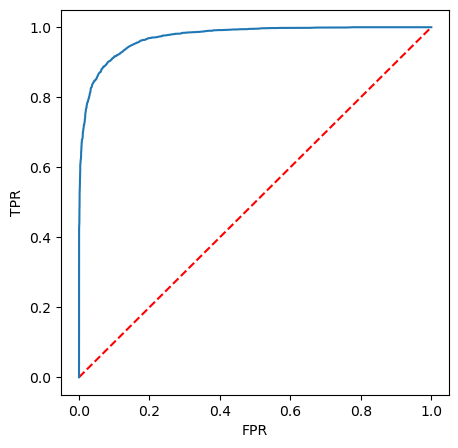

In [21]:
# Visualisation of Results

import matplotlib.pyplot as plt

plt.figure(figsize=(5,5))

plt.plot([0, 1], [0, 1], 'r--')
plt.plot(pipelineFit.stages[-1].summary.roc.select('FPR').collect(),
         pipelineFit.stages[-1].summary.roc.select('TPR').collect())

plt.xlabel('FPR')
plt.ylabel('TPR')

plt.show()


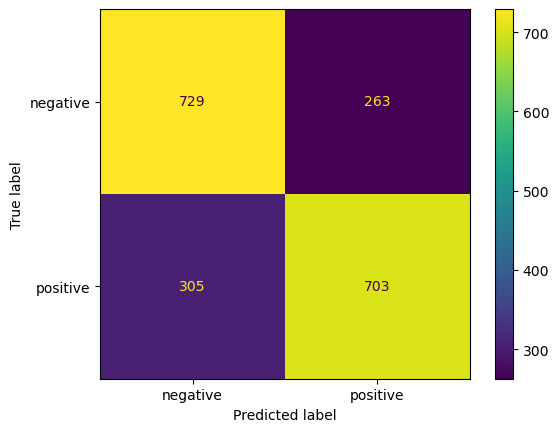

In [22]:
from sklearn.metrics import ConfusionMatrixDisplay

y_true = predictions.select(['label']).collect()
y_pred = predictions.select(['prediction']).collect()

ConfusionMatrixDisplay.from_predictions(y_true, y_pred, labels=[0.0, 1.0], display_labels=["negative", "positive"])

### 2. Naive Bayes Classifier

In [23]:
#Grid Search and Cross Validation 10-Fold

tokenizer = Tokenizer(inputCol="tweet", outputCol="words")
cv = CountVectorizer(vocabSize=2**16, inputCol="words", outputCol='cv')
idf = IDF(inputCol='cv', outputCol="features", minDocFreq=10) #minDocFreq: remove sparse terms

label_stringIdx = StringIndexer(inputCol = "target", outputCol = "label")

nb = NaiveBayes(modelType="multinomial")
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")

pipeline = Pipeline(stages=[tokenizer, cv, idf, label_stringIdx, nb])

param_grid = ParamGridBuilder().addGrid(nb.smoothing, [0.4, 0.6, 0.8]).build()
    
cv = CrossValidator(estimator=pipeline, estimatorParamMaps=param_grid, evaluator=evaluator, numFolds=10)

pipelineFit = cv.fit(train_set)

predictions = pipelineFit.transform(test_set)

accuracy = evaluator.evaluate(predictions, {evaluator.metricName: "accuracy"})
precision = evaluator.evaluate(predictions, {evaluator.metricName: "weightedPrecision"})
recall = evaluator.evaluate(predictions, {evaluator.metricName: "weightedRecall"})

# Print the results
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

bestModel = pipelineFit.bestModel
pipelineFit.getEstimatorParamMaps()[np.argmax(pipelineFit.avgMetrics)]

Accuracy: 0.721
Precision: 0.7210314492596996
Recall: 0.721


{Param(parent='NaiveBayes_f206c70a55e3', name='smoothing', doc='The smoothing parameter, should be >= 0, default is 1.0'): 0.4}

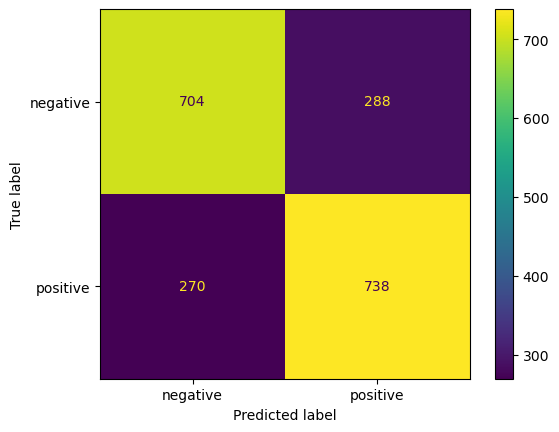

In [24]:
#Visualisation

from sklearn.metrics import ConfusionMatrixDisplay

y_true = predictions.select(['label']).collect()
y_pred = predictions.select(['prediction']).collect()

ConfusionMatrixDisplay.from_predictions(y_true, y_pred, labels=[0.0, 1.0], display_labels=["negative", "positive"])

### 3. Linear SVC (Support Vector Machine)

In [25]:
#Grid Search and Cross Validation - 10 Fold

tokenizer = Tokenizer(inputCol="tweet", outputCol="words")
cv = CountVectorizer(vocabSize=2**16, inputCol="words", outputCol='cv')
idf = IDF(inputCol='cv', outputCol="features", minDocFreq=10) #minDocFreq: remove sparse terms

label_stringIdx = StringIndexer(inputCol = "target", outputCol = "label")

svm = LinearSVC()
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")

pipeline = Pipeline(stages=[tokenizer, cv, idf, label_stringIdx, svm])

param_grid = ParamGridBuilder() \
    .addGrid(svm.regParam, [0.01, 0.1, 1]) \
    .build()
    
cv = CrossValidator(estimator=pipeline, estimatorParamMaps=param_grid, evaluator=evaluator, numFolds=10)

pipelineFit = cv.fit(train_set)

predictions = pipelineFit.transform(test_set)

accuracy = evaluator.evaluate(predictions, {evaluator.metricName: "accuracy"})
precision = evaluator.evaluate(predictions, {evaluator.metricName: "weightedPrecision"})
recall = evaluator.evaluate(predictions, {evaluator.metricName: "weightedRecall"})

# Print the results
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

bestModel = pipelineFit.bestModel
pipelineFit.getEstimatorParamMaps()[np.argmax(pipelineFit.avgMetrics)]

Accuracy: 0.7145
Precision: 0.7163337026381648
Recall: 0.7145


{Param(parent='LinearSVC_a3bb1bc189e6', name='regParam', doc='regularization parameter (>= 0).'): 0.01}

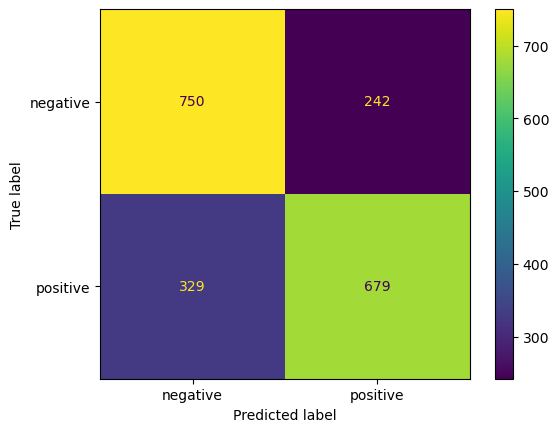

In [26]:
# Visualisation

from sklearn.metrics import ConfusionMatrixDisplay

y_true = predictions.select(['label']).collect()
y_pred = predictions.select(['prediction']).collect()

ConfusionMatrixDisplay.from_predictions(y_true, y_pred, labels=[0.0, 1.0], display_labels=["negative", "positive"])

## E) Evaluation and Comparison of ML Models Used

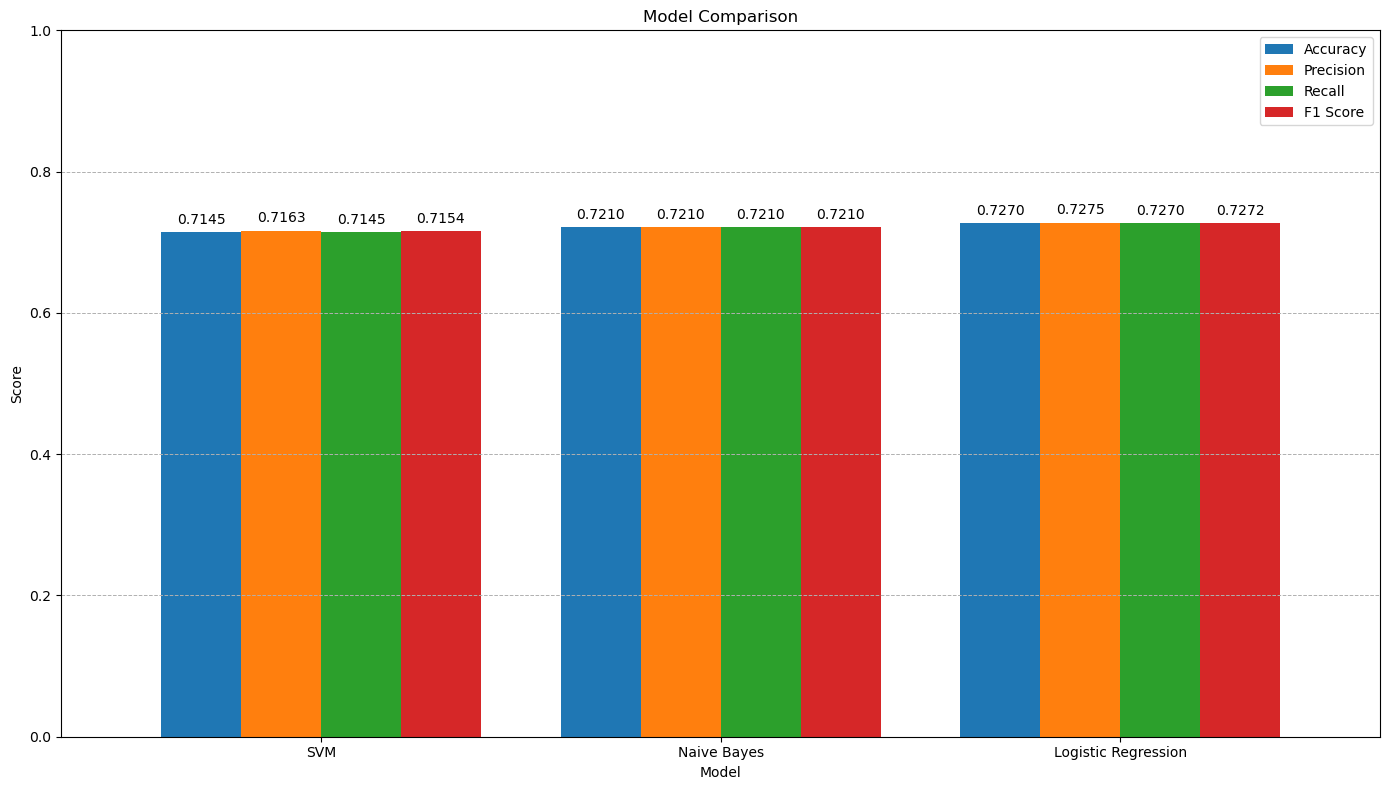

In [27]:
import matplotlib.pyplot as plt
import pandas as pd

# Metrics data
data = {
    'Model': ['SVM', 'Naive Bayes', 'Logistic Regression'],
    'Accuracy': [0.7145, 0.721, 0.727],
    'Precision': [0.7163337026381648, 0.7210314492596996, 0.7274927255907829],
    'Recall': [0.7145, 0.721, 0.727]
}

# Compute F1 Score
data['F1 Score'] = [2 * (data['Precision'][i] * data['Recall'][i]) / (data['Precision'][i] + data['Recall'][i]) for i in range(len(data['Model']))]

# Convert to DataFrame
df = pd.DataFrame(data)

# Set the index to 'Model' for easier plotting
df.set_index('Model', inplace=True)

# Plotting
ax = df.plot(kind='bar', figsize=(14, 8), width=0.8)
ax.set_ylabel('Score')
ax.set_title('Model Comparison')
ax.set_ylim(0, 1)
ax.grid(axis='y', linestyle='--', linewidth=0.7)

# Add the value labels on top of each bar
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.4f'), 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', 
                xytext=(0, 9), 
                textcoords='offset points')

plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


## F) Selection of Best Model(Logistic Regression)

In [28]:
#Pipeline1

tokenizer = Tokenizer(inputCol="tweet", outputCol="words")
hashtf = HashingTF(inputCol="words", outputCol='tf')
idf = IDF(inputCol='tf', outputCol="features")

label_stringIdx = StringIndexer(inputCol = "target", outputCol = "label")

lr = LogisticRegression()
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")

pipeline = Pipeline(stages=[tokenizer, hashtf, idf, label_stringIdx, lr])

pipelineFit1 = pipeline.fit(train_set)

predictions = pipelineFit1.transform(test_set)

accuracy = evaluator.evaluate(predictions, {evaluator.metricName: "accuracy"})
precision = evaluator.evaluate(predictions, {evaluator.metricName: "weightedPrecision"})
recall = evaluator.evaluate(predictions, {evaluator.metricName: "weightedRecall"})

# Print the results
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.668
Precision: 0.6691326378539493
Recall: 0.6679999999999999


In [29]:
#Pipeline2

tokenizer = Tokenizer(inputCol="tweet", outputCol="words")
hashtf = HashingTF(numFeatures=2**16, inputCol="words", outputCol='tf')
idf = IDF(inputCol='tf', outputCol="features", minDocFreq=10) #minDocFreq: remove sparse terms

label_stringIdx = StringIndexer(inputCol = "target", outputCol = "label")

lr = LogisticRegression()
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")

pipeline = Pipeline(stages=[tokenizer, hashtf, idf, label_stringIdx, lr])

pipelineFit2 = pipeline.fit(train_set)

predictions = pipelineFit2.transform(test_set)

accuracy = evaluator.evaluate(predictions, {evaluator.metricName: "accuracy"})
precision = evaluator.evaluate(predictions, {evaluator.metricName: "weightedPrecision"})
recall = evaluator.evaluate(predictions, {evaluator.metricName: "weightedRecall"})

# Print the results
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.6985
Precision: 0.6990957880196611
Recall: 0.6985


In [30]:
#Pipeline3

tokenizer = Tokenizer(inputCol="tweet", outputCol="words")
cv = CountVectorizer(inputCol="words", outputCol='cv')
idf = IDF(inputCol='cv', outputCol="features")

label_stringIdx = StringIndexer(inputCol = "target", outputCol = "label")

lr = LogisticRegression()
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")

pipeline = Pipeline(stages=[tokenizer, cv, idf, label_stringIdx, lr])

pipelineFit3 = pipeline.fit(train_set)

predictions = pipelineFit3.transform(test_set)

accuracy = evaluator.evaluate(predictions, {evaluator.metricName: "accuracy"})
precision = evaluator.evaluate(predictions, {evaluator.metricName: "weightedPrecision"})
recall = evaluator.evaluate(predictions, {evaluator.metricName: "weightedRecall"})

# Print the results
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.675
Precision: 0.6762545454545454
Recall: 0.675


In [31]:
#Pipeline4

tokenizer = Tokenizer(inputCol="tweet", outputCol="words")
cv = CountVectorizer(vocabSize=2**16, inputCol="words", outputCol='cv')
idf = IDF(inputCol='cv', outputCol="features", minDocFreq=10) #minDocFreq: remove sparse terms

label_stringIdx = StringIndexer(inputCol = "target", outputCol = "label")

lr = LogisticRegression()
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")

pipeline = Pipeline(stages=[tokenizer, cv, idf, label_stringIdx, lr])

pipelineFit4 = pipeline.fit(train_set)

predictions = pipelineFit4.transform(test_set)

accuracy = evaluator.evaluate(predictions, {evaluator.metricName: "accuracy"})
precision = evaluator.evaluate(predictions, {evaluator.metricName: "weightedPrecision"})
recall = evaluator.evaluate(predictions, {evaluator.metricName: "weightedRecall"})

# Print the results
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.7065
Precision: 0.7072554713361816
Recall: 0.7065


In [32]:
#Pipeline5

def build_trigrams(inputCol=["tweet", "target"], n=3):
    tokenizer = [Tokenizer(inputCol="tweet", outputCol="words")]

    ngrams = [
        NGram(n=i, inputCol="words", outputCol="{0}_grams".format(i))
        for i in range(1, n + 1)
    ]

    cv = [
        CountVectorizer(vocabSize=2 ** 14, inputCol="{0}_grams".format(i),
                        outputCol="{0}_tf".format(i))
        for i in range(1, n + 1)
    ]

    idf = [IDF(inputCol="{0}_tf".format(i), outputCol="{0}_tfidf".format(i), minDocFreq=5) for i in range(1, n + 1)]

    assembler = [VectorAssembler(
        inputCols=["{0}_tfidf".format(i) for i in range(1, n + 1)],
        outputCol="rawFeatures"
    )]

    label_stringIdx = [StringIndexer(inputCol="target", outputCol="label")]

    selector = [ChiSqSelector(numTopFeatures=2 ** 14, featuresCol='rawFeatures', outputCol="features")]

    lr = [LogisticRegression()]

    return Pipeline(stages=tokenizer + ngrams + cv + idf + assembler + label_stringIdx + selector + lr)

evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")

# entrainement
pipelineFit5 = build_trigrams().fit(train_set)

# lancement des predictions
predictions = pipelineFit5.transform(test_set)

accuracy = evaluator.evaluate(predictions, {evaluator.metricName: "accuracy"})
precision = evaluator.evaluate(predictions, {evaluator.metricName: "weightedPrecision"})
recall = evaluator.evaluate(predictions, {evaluator.metricName: "weightedRecall"})

# Print the results
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.6755
Precision: 0.6755173676563089
Recall: 0.6755


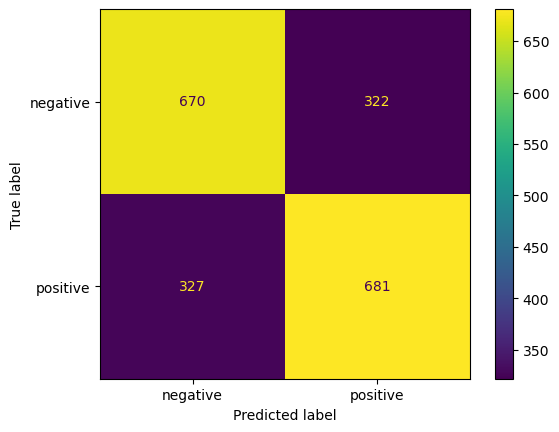

In [33]:
#Visualisations

y_true = predictions.select(['label']).collect()
y_pred = predictions.select(['prediction']).collect()

ConfusionMatrixDisplay.from_predictions(y_true, y_pred, labels=[0.0, 1.0], display_labels=["negative", "positive"])

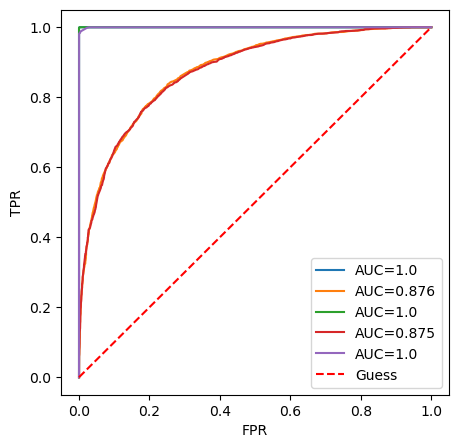

In [34]:
plt.figure(figsize=(5,5))

plt.plot(pipelineFit1.stages[-1].summary.roc.select('FPR').collect(),
         pipelineFit1.stages[-1].summary.roc.select('TPR').collect(),
        label="AUC=" +str(round(pipelineFit1.stages[-1].summary.areaUnderROC, 3)))

plt.plot(pipelineFit2.stages[-1].summary.roc.select('FPR').collect(),
         pipelineFit2.stages[-1].summary.roc.select('TPR').collect(),
        label="AUC=" +str(round(pipelineFit2.stages[-1].summary.areaUnderROC, 3)))

plt.plot(pipelineFit3.stages[-1].summary.roc.select('FPR').collect(),
         pipelineFit3.stages[-1].summary.roc.select('TPR').collect(),
        label="AUC=" +str(round(pipelineFit3.stages[-1].summary.areaUnderROC, 3)))

plt.plot(pipelineFit4.stages[-1].summary.roc.select('FPR').collect(),
         pipelineFit4.stages[-1].summary.roc.select('TPR').collect(),
        label="AUC=" +str(round(pipelineFit4.stages [-1].summary.areaUnderROC, 3)))


plt.plot(pipelineFit5.stages[-1].summary.roc.select('FPR').collect(),
         pipelineFit5.stages[-1].summary.roc.select('TPR').collect(),
        label="AUC=" +str(round(pipelineFit5.stages[-1].summary.areaUnderROC, 3)))

plt.plot([0, 1], [0, 1], "r--", label="Guess")

plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()
plt.show()